In [1]:
import requests
import pandas
from pandas import to_numeric
from bs4 import BeautifulSoup
from pykrx import stock as krx
import FinanceDataReader as fdr
from datetime import datetime, date, timedelta

import json
import urllib.request
from collections import namedtuple
from tqdm import tqdm
import sqlite3
from sqlite3 import Connection, Cursor, IntegrityError
from typing import NamedTuple

In [2]:
DBFILE = 'stock_prices.db'

In [3]:
# https://joo-ramzzi.tistory.com/7
# https://dkgkim.tistory.com/21
# https://github.com/sharebook-kr/pykrx

## Utility functions

In [4]:
class StockInfo(NamedTuple):
    종목명: str
    현재가: int
    현재가: int
    시총: str
    market_cap: int
    PER: int
    PBR: int

In [5]:
def get_price(code: str, cnt: int, period :str='day'):
    response = requests.get(f"https://fchart.stock.naver.com/sise.nhn?symbol={code}&requestType=0&count={cnt}&timeframe={period}")
    bs = BeautifulSoup(response.text, "html.parser")
    items = bs.find_all('item')
    price_data = []
    for item in items:
        data = item['data'].split('|')
        price_data.append(data)

    price_data = pandas.DataFrame(price_data, columns=["날짜", "시가", "고가", "저가", "종가", "거래량"])
    price_data.index = price_data["날짜"]
    price_data = price_data[["시가", "고가", "저가", "종가", "거래량"]]\
                        .rename(columns={
                            '시가':'Open',
                            '고가':'High',
                            '저가':'Low',
                            '종가':'Close',
                            '거래량':'Volume'
                        })
    price_data = price_data.apply(to_numeric)
    return price_data.iloc[::-1]

In [120]:
def get_stock_codes():
    code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', encoding='cp949')[0]
    code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)
    return code_df

In [7]:
def market_capitalization(item_code: str):
    url = "https://m.stock.naver.com/api/stock/%s/integration"%(item_code)
    #urllib.request를 통해 링크의 결과를 가져옵니다.
    raw_data = urllib.request.urlopen(url).read()
    #추후, 데이터 가공을 위해 json 형식으로 변경 합니다.
    json_data = json.loads(raw_data)

    #종목명 가져오기
    stock_name = json_data['stockName']

    #가격 가져오기
    current_price = json_data['dealTrendInfos'][0]['closePrice']

    #시총 가져오기
    for code in json_data['totalInfos']:
        if 'marketValue' == code['code']:
            marketSum_value = code['value']

    #PER 가져오기
    for i in json_data['totalInfos']:
        if 'per' == i['code']:
            per_value_str = i['value']

    #PBR 가져오기
    for v in json_data['totalInfos']:
        if 'pbr' == v['code']:
            pbr_value_str = v['value']

    return StockInfo(stock_name, current_price, marketSum_value, int(''.join([d for d in list(marketSum_value) if d in '0123456789'])), per_value_str, pbr_value_str)

In [8]:
def resample_df(df, period='W-FRI'):
    wm_df = pd.DataFrame()
    wm_df = pd.concat([wm_df, df[['Open']].resample(period).first()], axis=1)
    wm_df = pd.concat([wm_df, df[['High']].resample(period).max()], axis=1)
    wm_df = pd.concat([wm_df, df[['Low']].resample(period).min()], axis=1)
    wm_df = pd.concat([wm_df, df[['Close']].resample(period).last()], axis=1)
    wm_df = pd.concat([wm_df, df[['Volume']].resample(period).mean()], axis=1)
    return wm_df

In [9]:
# df_codes = get_stock_codes()
# df_ks_index = fdr.DataReader('KS11', date.today()-timedelta(days=480))[::-1]
# df_kq_index = fdr.DataReader('KQ11', date.today()-timedelta(days=480))[::-1]
# df_ks_stocks = fdr.StockListing('KOSPI') # KOSPI: 940 종목
# df_kq_stocks = fdr.StockListing('KOSDAQ') # KOSDAQ: 1,597 종목

## 사용법

```python
get_price("035720", 10, "week")

get_price(df_codes.종목코드[23], 10, 'week')

market_capitalization("373220")

stock.get_market_ohlcv("20200831", market="KOSPI") # KOSPI의 개별 종목 별 시고저종

# KOSPI Index 코스피 지수 데이터 
kospi_df = fdr.DataReader('KS11')
week_kospi_df = get_week_month_df(df, period='W-MON')
month_kospi_df = get_week_month_df(df, period='M')
```
출처: https://simpling.tistory.com/69 [simpling:티스토리]

In [10]:
def kospi_strong_stocks():    
    df_ks_index_week = resample_df(df_ks_index, period='W-FRI')[::-1]
    date = df_ks_index_week[:52]["Low"].idxmin()
    lowest = df_ks_index_week.loc[date, "Low"]
    currval = df_ks_index.iloc[0]["Close"] 
    ks_rate = (currval - lowest)/lowest*100
    res = []
    for code in tqdm(df_ks_stocks["Code"]):
        df_week = get_price(code, 52, "week")
        date = df_week[:52]["Low"].idxmin()
        lowest = df_week.loc[date, "Low"]
        currval = get_price(code, 1, "day").iloc[0]["Close"]
        rate = (currval - lowest)/lowest*100
        if (rate > ks_rate):            
            res.append([code, rate, market_capitalization(code).market_cap])
    
    return ks_rate, pd.DataFrame(res, columns=["code", "rate", "marcap"])

In [11]:
from pydantic import BaseModel

class StockPrice(BaseModel):
    code: str
    market: str
    date: str
    open: float
    high: float
    low: float
    close: float
    volume: float

In [12]:
def db_insert(curs: Cursor, info: StockPrice):
    qry = "insert into StockPrice values" \
          "(:code, :market, :date, :open, :high, :low, :close, :volume)"
    params = info.model_dump()
    curs.execute(qry, params)

In [11]:
def get_ohlc(curs: Cursor, code: str, start_date: str|None=None, end_date: str|None=None):
    qry = "select * from StockPrice where code=:code "
    if start_date and end_date:
        qry += f"AND date BETWEEN '{start_date}' and '{end_date}'"
    params = {"code": code}
    curs.execute(qry, params)
    res = curs.fetchall()
    df = pd.DataFrame(res, columns=["Code", "Market", "Date", "Open", "High", "Low", "Close", "Volume"])
    return df

In [14]:
def get_stock_list(curs: Cursor, market: str):
    qry = f"select DISTINCT code from StockPrice where market='{market}'"
    curs.execute(qry)
    return curs.fetchall() 

In [15]:
def build_stock_price_db(dbfile: str, start_date: str, end_date: str):
    conn = sqlite3.connect(dbfile)
    curs = conn.cursor()
    curs.execute("create table if not exists \
    StockPrice(code text, market text, \
    date text, open, high, low, close, volume, constraint pkey primary key(code, date))")
    def build(stock_list: list, market: str):
        for code in tqdm(stock_list, desc=market):
            df = fdr.DataReader(code, start_date, end_date).reset_index()
            for _, row in df.iterrows():
                sp = StockPrice(code=code, 
                                market=market, 
                                date=row['Date'].strftime('%Y-%m-%d'), 
                                open=row['Open'],
                                high=row['High'],
                                low=row['Low'],
                                close=row['Close'],
                                volume=row['Volume'])
                try:
                    db_insert(curs, sp)                    
                except IntegrityError:
                    pass
    build(fdr.StockListing('KOSPI')['Code'], 'kospi')
    build(['KS11'], 'KS11')
    build(fdr.StockListing('KOSDAQ')['Code'], 'kosdaq')
    build(['KQ11'], 'KQ11')
    conn.commit()
    conn.close()

In [16]:
def update_stock_price_db(dbfile: str):
    conn = sqlite3.connect(dbfile)
    curs = conn.cursor()
    qry = "select DISTINCT code, market from StockPrice"
    curs.execute(qry)
    res = curs.fetchall() 
    for code, market in tqdm(res):
        qry = "select MAX(date) from StockPrice where code=:code"
        params = {"code": code}
        curs.execute(qry, params)
        res = curs.fetchall()
        start_date = res[0][0]
        today = date.today()
        if today == start_date:
            continue
        df = fdr.DataReader(code, start_date, today.strftime("%Y-%m-%d")).reset_index()
        for _, row in df.iterrows():
            sp = StockPrice(code=code, 
                            market=market, 
                            date=row['Date'].strftime('%Y-%m-%d'), 
                            open=row['Open'],
                            high=row['High'],
                            low=row['Low'],
                            close=row['Close'],
                            volume=row['Volume'])
            try:
                db_insert(curs, sp)                    
            except IntegrityError:
                pass
    conn.commit()
    conn.close()

In [17]:
def oneday_update_stock_price_db(dbfile: str, date_: str|None = None):
    conn = sqlite3.connect(dbfile)
    curs = conn.cursor()
    if not date_:
        date_ = date.today().strftime("%Y-%m-%d")
        
    def update(df, market):
        for _, row in df.iterrows():
            sp = StockPrice(code=row['Code'], 
                            market=market, 
                            date=date_, 
                            open=row['Open'],
                            high=row['High'],
                            low=row['Low'],
                            close=row['Close'],
                            volume=row['Volume'])
            try:
                db_insert(curs, sp)
            except IntegrityError:
                pass          
        
    columns = {'티커':'Code','시가':'Open', '고가':'High', '저가':'Low', '종가':'Close', '거래량':'Volume'}
    df = krx.get_market_ohlcv(date_, market='KOSPI').reset_index()
    df = df.rename(columns=columns)
    if df.values.any():
        update(df, 'kospi')
        
    df = krx.get_market_ohlcv(date_, market='KOSDAQ').reset_index()
    df = df.rename(columns=columns)
    if df.values.any():
        update(df, 'kosdaq')
     
    for code in ['KS11', 'KQ11']:
        df = fdr.DataReader(code, date_, date_).reset_index()
        df['Code'] = code
        update(df, code)
        
    conn.commit()
    conn.close()    

In [108]:
# build_stock_price_db(DBFILE, '2022-01-01', '2024-07-31')

In [109]:
# update_stock_price_db(DBFILE)

In [112]:
# oneday_update_stock_price_db(DBFILE)

1 001 2024-08-03 00:00:00 2026-08-02 00:00:00
no data or code("1001") not found
2 001 2024-08-03 00:00:00 2026-08-02 00:00:00
no data or code("2001") not found


In [235]:
def strong_stocks(curs: Cursor, market: str):
    if market.lower() == 'kospi':
        market_ = 'KS11'
    elif market.lower() == 'kosdaq':
        market_ = 'KQ11'
    else:
        assert False, "wrong market"
    
    df = get_ohlc(curs, market_)
    df['Date'] = pd.to_datetime(df['Date'])
    df_market_index = df.set_index('Date')    
    df_market_index_week = resample_df(df_market_index, period='W-FRI')[::-1]
    date = df_market_index_week[:52]["Low"].idxmin()
    lowest = df_market_index_week.loc[date, "Low"]
    currval = df_market_index_week.iloc[0]["Close"] 
    ks_rate = (currval - lowest)/lowest*100
    res = []
    codes = [x[0] for x in get_stock_list(curs, market.lower())]
    last_date = df_market_index.index.max()
    start_date = last_date - timedelta(days=400)
    df_marcap = krx.get_market_cap(last_date.strftime('%Y-%m-%d'))
    for code in tqdm(codes):
        df = get_ohlc(curs, code, start_date.strftime('%Y-%m-%d'), last_date.strftime('%Y-%m-%d'))
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        df_week = resample_df(df, period='W-FRI')[::-1]
        if len(df_week) < 52:
            continue
        date = df_week[:52]["Low"].idxmin()        
        lowest = df_week.loc[date, "Low"]
        if lowest == 0:
            continue
        currval = df["Close"].iloc[-1]
        rate = (currval - lowest)/lowest*100
        if (rate > ks_rate):            
            res.append([code, rate, df_marcap.loc[code, "시가총액"]])
    
    return ks_rate, pd.DataFrame(res, columns=["code", "rate", "marcap"])

In [236]:
conn = sqlite3.connect(DBFILE)
curs = conn.cursor()

In [242]:
ks_rate, df = strong_stocks(curs, 'kosdaq')

100%|██████████████████████████████████████████████████████████████████████████████| 1746/1746 [00:23<00:00, 74.96it/s]


In [243]:
df[df['rate'] > 30]

,code,rate,marcap
0,000250,223.423423,4210616224000
1,000440,48.355059,148828407000
5,001840,56.541020,69914332800
8,002800,48.817204,104979860000
11,005160,41.676505,325466892000
...,...,...,...
839,900290,36.842105,201451250000
842,900340,146.099291,83233897580
844,950140,86.263736,336760328700
845,950160,125.291829,1378513858050


In [241]:
get_ohlc(curs, '000100')

,Code,Market,Date,Open,High,Low,Close,Volume
0,000100,kospi,2022-01-03,56854.0,58135.0,56762.0,58045.0,174870.0
1,000100,kospi,2022-01-04,58319.0,58319.0,56762.0,56946.0,175334.0
2,000100,kospi,2022-01-05,56578.0,56670.0,55479.0,55938.0,220258.0
3,000100,kospi,2022-01-06,55113.0,56304.0,55023.0,55023.0,183085.0
4,000100,kospi,2022-01-07,55021.0,56211.0,54655.0,55663.0,162565.0
...,...,...,...,...,...,...,...,...
633,000100,kospi,2024-07-30,96300.0,97600.0,94600.0,97600.0,794408.0
634,000100,kospi,2024-07-31,98100.0,99000.0,89500.0,94400.0,1779758.0
635,000100,kospi,2024-08-01,93300.0,95000.0,91700.0,92000.0,721342.0
636,000100,kospi,2024-08-02,90600.0,92100.0,89900.0,90800.0,606631.0


In [23]:
df = krx.get_market_ohlcv("2024-08-23", market="KOSDAQ")
df.head(3)

,시가,고가,저가,종가,거래량,거래대금,등락률
티커,,,,,,,
060310,2145,2180,2130,2165,145668,313038565,-0.92
054620,6480,6490,6200,6310,11660,73648550,-1.41
265520,19120,19300,19020,19290,46383,888839770,-0.31


In [24]:
df.shape

(1752, 7)

In [25]:
fdr.DataReader('060310', '2024-08-22' , '2024-08-24')

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-08-22,2205,2235,2170,2185,341855,-0.009070
2024-08-23,2145,2180,2130,2165,144961,-0.009153


In [30]:
d = fdr.DataReader('KS11', '2024-08-21' , date.today()).index[-1]
print(d)
krx.get_market_ohlcv(d, market="KOSPI")

1 001 2024-08-21 00:00:00 2026-08-20 00:00:00
2024-08-23 00:00:00


,시가,고가,저가,종가,거래량,거래대금,등락률
티커,,,,,,,
095570,4560,4640,4560,4620,44269,203510350,0.22
006840,13000,13000,12800,12880,5647,72822950,-0.92
027410,3470,3500,3470,3500,28504,99504790,0.00
282330,111400,114200,110000,112700,32993,3722922300,1.71
138930,9930,10080,9830,10030,945457,9455680820,1.01
...,...,...,...,...,...,...,...
079980,3135,3160,3095,3140,23804,74115515,0.00
005010,3995,4040,3980,4020,146408,587130840,0.63
000540,4000,4100,3935,4090,71370,286119325,3.15


In [34]:
fdr.DataReader('KS11', '2024-08-21' , date.today()).index

1 001 2024-08-21 00:00:00 2026-08-20 00:00:00


DatetimeIndex(['2024-08-21', '2024-08-22', '2024-08-23'], dtype='datetime64[ns]', name='Date', freq=None)

In [37]:
conn = sqlite3.connect(DBFILE)
curs = conn.cursor()

get_ohlc(curs, '093240', '2024-05-28', '2024-05-28')

,Code,Market,Date,Open,High,Low,Close,Volume
0,093240,kospi,2024-05-28,1239.0,1362.0,1207.0,1208.0,2525595.0


In [7]:
import market

def get_won_volume_stock(date_: str|None=None):
    df = pd.concat([market.get_2days_prices('kospi', date_), market.get_2days_prices('kosdaq', date_)], axis=0)
    df = df.groupby('Code').filter(lambda x: len(x)>1)
    df = df.sort_values(["Code", "Date"])
    d1, d0 = df['Date'].unique()
    df_today = df[df['Date']==d0].pipe(lambda x: x.assign(won_vol=lambda x: 0.5*(x['High'] + x['Low'])*x['Volume']))\
                                .sort_values('won_vol', ascending=False).iloc[:30, :].set_index("Code")

    df_rate = df.groupby('Code')['Close'].apply(lambda x: 100*(x.values[1]-x.values[0])/x.values[0])\
                                        .rename('rate').to_frame()
    df = df_today[['won_vol', 'Market', 'Volume']].join(df_rate['rate'])\
                        .sort_values('won_vol', ascending=False)[:30]\
                        .pipe(lambda x: x[x['rate'] >= 5]).reset_index(drop=False)    
    df['name'] = df['Code'].map(lambda x: krx.get_market_ticker_name(x))
    return df # Date, won_vol, Market, rate, name, Volume

In [8]:


aa = get_won_volume_stock("2024-06-01")["name"].values

In [11]:
bb = get_won_volume_stock("2024-06-03")["name"].values

In [9]:
aa

array(['와이씨', 'SK', '엔켐', '대한해운', '노브랜드', '우리기술', '삼천당제약', '디아이', '피엔티'],
      dtype=object)

In [13]:
bb

array(['한화에어로스페이스', '한국가스공사', '포스코인터내셔널', '유한양행', '실리콘투', '와이랩', '알테오젠',
       '흥구석유', 'LS마린솔루션', 'HMM', '삼양식품', 'SK이노베이션', '지에스이', '브이티',
       '대성에너지'], dtype=object)

In [14]:
set(bb) - set(aa)

{'HMM',
 'LS마린솔루션',
 'SK이노베이션',
 '대성에너지',
 '브이티',
 '삼양식품',
 '실리콘투',
 '알테오젠',
 '와이랩',
 '유한양행',
 '지에스이',
 '포스코인터내셔널',
 '한국가스공사',
 '한화에어로스페이스',
 '흥구석유'}

In [15]:
set(aa) - set(bb)

{'SK', '노브랜드', '대한해운', '디아이', '삼천당제약', '엔켐', '와이씨', '우리기술', '피엔티'}

In [17]:
set(aa).intersection(set(bb))

set()

In [38]:
import networkx as nx
from itertools import chain, combinations

In [3]:
conn = sqlite3.connect(DBFILE)
curs = conn.cursor()

In [17]:
dates = get_ohlc(curs, 'KS11')['Date']

In [21]:
get_won_volume_stock(dates[1])

,Code,won_vol,Market,Volume,rate,name
0,108490,5.256327e+11,kosdaq,14985964.0,7.788162,로보티즈
1,215100,3.569883e+11,kosdaq,45592373.0,25.797101,로보로보
2,357880,3.273462e+11,kosdaq,16851798.0,29.824561,비트나인
3,039240,2.633978e+11,kosdaq,45570553.0,15.163148,경남스틸
4,039290,2.618461e+11,kosdaq,10061328.0,9.523810,인포뱅크
5,053800,2.428678e+11,kosdaq,2344284.0,6.293706,안랩
6,402340,2.167748e+11,kospi,3183183.0,5.263158,SK스퀘어
7,193250,1.974690e+11,kosdaq,48251430.0,9.806452,링크드
8,002380,1.974240e+11,kospi,548781.0,25.404531,KCC
9,249420,1.627476e+11,kospi,4464955.0,6.534091,일동제약


In [57]:
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rc('font', family='NanumGothic')

In [66]:
G = nx.Graph()

In [67]:
for _date in tqdm(dates[1:]):
    df = get_won_volume_stock(_date)
    stocks = df["Code"].values
    code_name = dict(zip(df["Code"].values, df["name"].values))
    for a, b in combinations(stocks, 2):
        if (a, b) in G.edges:
            G.edges[a, b]['weight'] += 1
        else:
            G.add_edge(a, b, weight=1)
            G.nodes[a]["name"] = code_name[a]
            G.nodes[b]["name"] = code_name[b]

100%|████████████████████████████████████████████████████████████████████████████████| 655/655 [17:36<00:00,  1.61s/it]


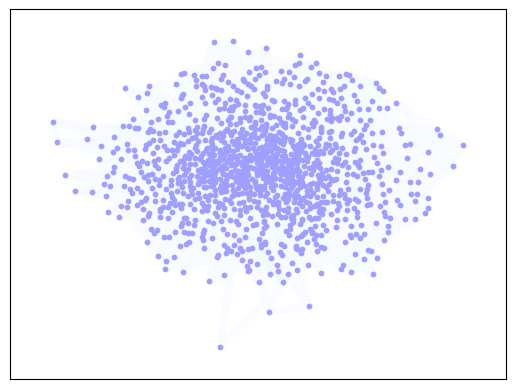

In [68]:
pos = nx.spring_layout(G, k=0.3)
weight = [G.edges[e]['weight'] for e in G.edges]
nx.draw_networkx_edges(G, pos, edge_color=weight, edge_cmap=plt.cm.Blues, width=6, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color="#9f9fff", node_size=10)

In [71]:
pd.Series([G.edges[e]['weight'] for e in G.edges]).value_counts()

1     21655
2      2663
3       693
4       220
5       105
6        42
7        31
8        17
9         9
10        7
11        4
13        2
16        2
14        1
28        1
22        1
12        1
15        1
Name: count, dtype: int64

In [115]:
N = 10
edges = [e for e in G.edges if G.edges[e]['weight'] >= N]
weights = [G.edges[e]['weight'] for e in G.edges if G.edges[e]['weight'] >= N]
nodes = [(s, t) for (s,t,d) in G.edges(data=True) if d['weight'] >= N]
nodes = sum([list(x) for x in nodes], [])

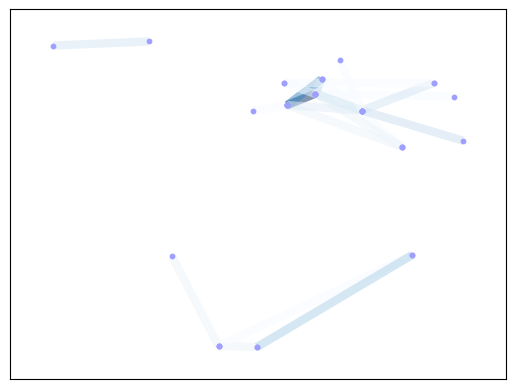

In [116]:
nx.draw_networkx_edges(G, pos, edges, edge_color=weights, edge_cmap=plt.cm.Blues, width=6, alpha=0.5)
nx.draw_networkx_nodes(G, pos, nodes, node_color="#9f9fff", node_size=10)

In [125]:
[(code_name[x[0]], code_name[x[1]]) for x in edges]

[('바이오니아', '에코프로'),
 ('삼성SDI', '에코프로비엠'),
 ('엘앤에프', '에코프로비엠'),
 ('엘앤에프', '포스코퓨처엠'),
 ('엘앤에프', '에코프로'),
 ('신성델타테크', '파워로직스'),
 ('흥구석유', '한국석유공업'),
 ('미래나노텍', '금양'),
 ('에코프로비엠', '에코프로'),
 ('에코프로비엠', '포스코퓨처엠'),
 ('에코프로비엠', '금양'),
 ('한국석유공업', '대성에너지'),
 ('한국석유공업', '지에스이'),
 ('지에스이', '대성에너지'),
 ('에코프로', '금양'),
 ('에코프로', '포스코퓨처엠'),
 ('포스코엠텍', '금양'),
 ('포스코엠텍', '포스코인터내셔널'),
 ('금양', '레인보우로보틱스'),
 ('금양', '포스코인터내셔널')]

In [117]:
len(nodes)

40

In [122]:
df = get_stock_codes()

D:\Programs\miniconda3\Lib\site-packages\bs4\__init__.py:228: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


In [137]:
code_name = dict(zip(df['종목코드'].values, df['회사명'].values))

In [138]:
df

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,BGF리테일,282330,종합 소매업,체인화 편의점,2017-12-08,12월,민승배,http://www.bgfretail.com,서울특별시
1,DRB동일,004840,고무제품 제조업,"고무벨트(V벨트,콘베이어벨트,평벨트),프라스틱제품 제조,판매",1976-05-21,12월,류영식,http://www.drbworld.com,부산광역시
2,E1,017940,기타 전문 도매업,"LPG(프로판,부탄가스),가스기기판매",1997-08-27,12월,"구자용, 천정식 (각자 대표이사)",http://www.e1.co.kr,서울특별시
3,HDC현대산업개발,294870,건물 건설업,"외주주택, 자체공사, 일반건축, 토목 등",2018-06-12,12월,"최익훈, 김회언, 조태제 (각자 대표이사)",http://www.hdc-dvp.com,서울특별시
4,HD현대마린솔루션,443060,"건축기술, 엔지니어링 및 관련 기술 서비스업","AM(After Market) 솔루션, 친환경 Retrofit, 디지털 제어",2024-05-08,12월,이기동,http://www.hd-marinesolution.com/,부산광역시
...,...,...,...,...,...,...,...,...,...
2710,이앤에치,341310,기타 섬유제품 제조업,"미세먼지용 HEPA 소재, 차량용 캐빈필터소재, 마스크용 소재",2019-12-27,12월,"김정운, 유병덕(공동 대표이사)",http://www.hepabest.com,경기도
2711,큐러블,086460,자연과학 및 공학 연구개발업,유전체 분석 서비스,2013-07-01,12월,김승일,http://www.snp-genetics.com,경기도
2712,타스컴,336040,의료용 기기 제조업,당뇨질환 세포치료제 / 당뇨관리 의료기기,2019-12-02,12월,이인근,http://www.yidobio.com,경기도
2713,테크엔,308700,전구 및 조명장치 제조업,LED조명장치,2018-12-21,12월,박철,http://www.techen.co.kr,대구광역시


In [141]:
[(code_name[x[0]], x[1]) for x in sorted(G.degree(weight='weight'), key = lambda x: x[1], reverse=True) if x[0] in code_name]


[('에코프로', 797),
 ('에코프로비엠', 680),
 ('금양', 636),
 ('포스코퓨처엠', 510),
 ('엘앤에프', 489),
 ('레인보우로보틱스', 431),
 ('알테오젠', 402),
 ('포스코DX', 401),
 ('한미반도체', 390),
 ('신성델타테크', 387),
 ('포스코엠텍', 368),
 ('위메이드', 359),
 ('지에스이', 359),
 ('이수페타시스', 349),
 ('HLB', 345),
 ('미래나노텍', 343),
 ('일동제약', 326),
 ('LG화학', 325),
 ('현대사료', 316),
 ('휴마시스', 309),
 ('엔켐', 298),
 ('제주반도체', 296),
 ('POSCO홀딩스', 292),
 ('하이드로리튬', 292),
 ('한일사료', 286),
 ('한화에어로스페이스', 286),
 ('HPSP', 274),
 ('SK이노베이션', 269),
 ('코스모신소재', 269),
 ('포스코인터내셔널', 269),
 ('삼부토건', 257),
 ('LS에코에너지', 256),
 ('바이오니아', 249),
 ('삼성SDI', 245),
 ('루닛', 242),
 ('한국석유공업', 233),
 ('흥구석유', 232),
 ('두산에너빌리티', 231),
 ('이수스페셜티케미컬', 230),
 ('대한전선', 229),
 ('가온칩스', 228),
 ('제주은행', 228),
 ('SK하이닉스', 223),
 ('솔트룩스', 222),
 ('에코프로머티', 221),
 ('두산로보틱스', 217),
 ('오픈엣지테크놀로지', 214),
 ('휴림로봇', 213),
 ('미래생명자원', 212),
 ('코스모화학', 210),
 ('에코프로에이치엔', 208),
 ('현대로템', 205),
 ('엘에스일렉트릭', 205),
 ('삼천당제약', 204),
 ('셀바스AI', 202),
 ('셀트리온', 201),
 ('이수화학', 201),
 ('팜스토리', 198),
 ('L